### Linear Regression - Feature columns: Date Time + Zone || Prediction: Pickup count by Zone || Pickup counts  Labels

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../../data/picklerCheckpoints/"
is_compressed = True;

In [2]:
!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install imblearn
import nbimporter
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
import time
import math
import seaborn as sns
plt.rcParams.update({'font.size': 22})

You should consider upgrading via the 'D:\python\python.exe -m pip install --upgrade pip' command.


Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\SpatialMapping.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\commons\utility\pickle_util.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\DataEnrichment.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb


In [3]:
data = sm.run(['apr', 'may', 'jun', 'jul', 'aug'])

Data for the month :apr Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :may Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :jun Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file

In [4]:
df = data.copy()
columns = ['datetime', 'zone']

In [5]:
df2 = df[columns]
df2g = dis.encode(df2, ['zone'])
df2g = df2.groupby(columns).size().reset_index(name='counts')
df2g['datetime'] = pd.to_datetime(df2g['datetime'], format='%m-%d-%Y:%H').apply(lambda x: time.mktime(x.timetuple()))

D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


Result Saved in ../data/encodedMappings/zone.p


In [6]:
from sklearn.preprocessing import MinMaxScaler
counts = df2g['counts'].copy()
datetime = df2g['datetime'].copy()

In [8]:
# bins = [0, 10, 50, np.inf]
# names = ['low', 'med', 'high']

df2g['label'] = df2g['counts']

In [40]:
# df2g = dis.encode(df2g, ['label'])

In [10]:
# class0, class1, class2 = df2g['label'].value_counts()

In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=101)

In [12]:
x_ros, y_ros = ros.fit_resample(df2g[columns], df2g['label'])
df3 = x_ros
df3['label'] = y_ros

In [13]:
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df3) 
df3.loc[:,:] = scaled_values
df3['counts'] = counts
df3['datetime'] = datetime

In [14]:
x_ros

,datetime,zone,label,counts
0,1.396291e+09,0.046875,0.000000,3
1,1.396291e+09,0.335938,0.001786,1
2,1.396291e+09,0.550781,0.003571,2
3,1.396291e+09,0.000000,0.005357,1
4,1.396291e+09,0.191406,0.007143,1
...,...,...,...,...
387,1.396312e+09,0.601562,0.864286,1
388,1.396312e+09,0.601562,0.912500,8
389,1.396312e+09,0.601562,0.919643,2
390,1.396312e+09,0.601562,0.964286,1


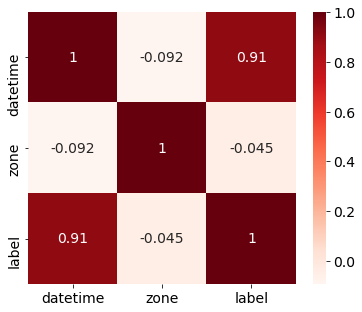

In [15]:
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 14})
corrCols = columns.copy()
corrCols.append('label')
cor = df3[corrCols].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('LinearRegression/LR-1-Correlation.png')
plt.show()

In [16]:
#Correlation with output variable
cor_target = abs(cor["label"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

datetime    0.909276
label       1.000000
Name: label, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split( df3[columns], df3['label'], test_size=0.33, random_state=100)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [20]:
model = LinearRegression()
startTr = int(round(time.time() * 1000))
trained = model.fit(X_train, y_train)
endTr = int(round(time.time() * 1000))

In [21]:
startTe = int(round(time.time() * 1000))
x_predict = model.predict(X_test)
endTe = int(round(time.time() * 1000))

In [22]:
testDf = pd.DataFrame(X_test, columns=columns)
testDf['label'] = y_test
testDf.loc[:,:] = scaler.inverse_transform(testDf)
predictedDf = pd.DataFrame(X_test, columns=columns)
predictedDf['label'] = x_predict
predictedDf.loc[:,:] = scaler.inverse_transform(predictedDf)
predictedDf['label'] = predictedDf['label'].astype(int)

In [23]:
y_test = testDf['label'].astype(int)
x_predict = predictedDf['label']

In [24]:
from sklearn import metrics

In [25]:
print(metrics.mean_absolute_error(y_test, x_predict))
print(metrics.mean_squared_error(y_test, x_predict))
print(metrics.r2_score(y_test, x_predict))

39.58461538461538
2513.230769230769
0.8355794469601414


In [26]:
from sklearn.metrics import classification_report

In [27]:
report = classification_report(y_test, x_predict)
print(report)

              precision    recall  f1-score   support

          -8       0.00      0.00      0.00         0
          -7       0.00      0.00      0.00         0
          -5       0.00      0.00      0.00         0
          -4       0.00      0.00      0.00         0
          -3       0.00      0.00      0.00         0
          -2       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          19       0.00    

D:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-sc

In [28]:
# report = classification_report(y_testdf['label'],  x_predictdf['label'])
# print(report)

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA(n_components=2)

In [31]:
pca.fit(X_train)

PCA(n_components=2)

In [32]:
print(pca.explained_variance_ratio_)

[9.99999999e-01 1.31073726e-09]


In [33]:
print(pca.singular_values_)

[1.09872845e+05 3.97784809e+00]


In [34]:
transformed = pd.DataFrame(pca.fit_transform(X_test))


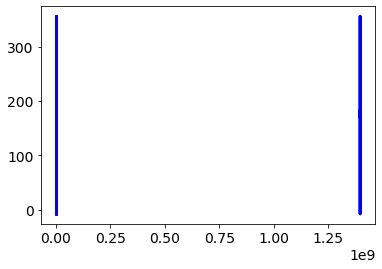

In [35]:
plt.plot(X_test, x_predict, color='blue', linewidth=3)

In [36]:
len(x_predict)

130

No handles with labels found to put in legend.


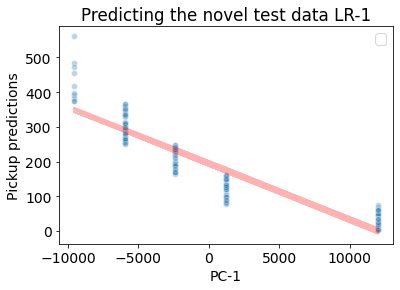

In [37]:
plt.scatter(transformed[0], y_test, edgecolors='w', alpha=0.3)
plt.plot(transformed[0], x_predict, color='r', alpha=0.3)
plt.legend()
plt.xlabel('PC-1')
plt.ylabel('Pickup predictions')
plt.title('Predicting the novel test data LR-1')
plt.savefig('LinearRegression/LR-1.png')
plt.show()

In [38]:
print("Training time: = %3d ms" %(endTr-startTr))

Training time: =  20 ms


In [39]:
print("Testing time: = %3d ms" %(endTe-startTe))

Testing time: =   3 ms
